# Master model development

## John Brandt

### Last updated: November 1 2019

*  Package loading
*  Hyperparameter definitions
*  Additional layer definitions
*  Model definition
*  Data loading
*  Data preprocessing
*  K means clustering
*  Augment training data
*  Loss definition
*  Equibatch creation
*  Model training
*  Model validation and sanity checks

In [1]:
# Notes
# The model is very sensitive to zoneout prob, do not go above 0.05/
# AdaBound seems to perform worse, stick to Adam with step down loss
# 32 x 24 x 32 model overfits after 100 epochs
# Investigate more hypercolumn parametrizations to increase available data at output 
#    while maintaining low dimensionality of filters
# 5e-4 LR worked, investigating 8e-4 for 60% faster training time
# ONLY CHANGE ONE THING AT A TIME

In [2]:
#TODO Remove imports that aren't needed to save RAM
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from tensorflow.python.keras.activations import selu
from tensorflow.initializers import glorot_normal, lecun_normal
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add, Bidirectional, ConvLSTM2D

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import conv2d

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import itertools
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [3]:
%run ../src/zoneout.py
%run ../src/convgru.py
%run ../src/lovasz.py
%run ../src/utils.py
%run ../src/adabound.py
%run ../src/slope.py
%run ../src/dropblock.py

# Hyperparameter definitions

In [4]:
ZONE_OUT_PROB = 0.05
L2_REG = 0.0
INITIAL_LR = 2e-4
FINAL_LR = 1e-3
BN_MOMENTUM = 0.9
BATCH_SIZE = 16
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
MAX_DROPBLOCK = 0.85

STEPS = 12

gru_flt = 12
fpa_flt = 64
out_conv_flt = 96


AUGMENTATION_RATIO = 4
IMAGE_SIZE = 14
existing = [int(x[:-4]) for x in os.listdir('../data/final/') if ".DS" not in x]
N_SAMPLES = len(existing)

LABEL_SIZE = 14

    
TRAIN_SAMPLES = int((N_SAMPLES * AUGMENTATION_RATIO) * TRAIN_RATIO)
TEST_SAMPLES = int((N_SAMPLES * AUGMENTATION_RATIO) - TRAIN_SAMPLES)
print(TRAIN_SAMPLES // AUGMENTATION_RATIO, N_SAMPLES - (TRAIN_SAMPLES // AUGMENTATION_RATIO))

539 135


# Additional layer definitions

In [5]:
def conv_bn_elu(inp, is_training, kernel_size, scope, filter_count = 16, pad = True, padding = 'valid', dilated = False):
    if not dilated:
        padded = ReflectionPadding2D((1, 1,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = selu,
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    if not dilated and not pad:
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = selu,
                        padding = padding, kernel_initializer = lecun_normal())(inp)
    if dilated:
        padded = ReflectionPadding2D((2, 2,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (3, 3), activation = selu, dilation_rate = (2, 2),
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    return conv

def td_conv_bn_elu(inp, filter_count = 32, size = 3):
    #padded = TimeDistributed(ReflectionPadding2D((1, 1,)))(inp)
    if size == 3:
        padded = tf.pad(inp, [[0,0], [0,0], [1,1], [1,1], [0,0] ], 'REFLECT')
        conv = TimeDistributed(Conv2D(filters = filter_count, kernel_size = (3, 3),
                          padding = 'valid', activation = selu, kernel_initializer = lecun_normal()))(padded)
    else:
        conv = TimeDistributed(Conv2D(filters = filter_count, kernel_size = (1, 1),
                          padding = 'valid', activation = selu, kernel_initializer = lecun_normal()))(inp)
    #bn = TimeDistributed(Batch_Normalization(elu, training=is_training, scope = scope + "bn")
    return conv

def upconv2d(X, filters, is_training, amt, scope):
    X = tf.image.resize_images(X, [X.shape[1]+amt, X.shape[2]+amt],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    X = conv_bn_elu(X, is_training, 1, scope, filters, False, 'valid')
    return X
    
    
def fpa(inp, is_training, filter_count, scope):
    one = conv_bn_elu(inp, is_training, 1, scope + 'forward1', filter_count, False, 'valid')
    three = conv_bn_elu(inp, is_training, 3, scope + 'down2', filter_count, True, 'valid') 
    five = conv_bn_elu(inp, is_training, 3, scope + 'down2', filter_count, True, 'valid', dilated = True) 
    concat_1 = tf.multiply(one, tf.add(three, five))
    return concat_1

def inp_fpa(inp, is_training, filter_count, scope):
    one = td_conv_bn_elu(inp, filter_count, 1)
    three = td_conv_bn_elu(inp, filter_count, 3)
    concat_1 = tf.multiply(one, three)
    return concat_1

def dist_fpa(inp, is_training, filter_count, length):
    one, one_f = gru_block(inp = inp, length = length, size = [14, 14], kernel_size = 1,
                    flt = filter_count, scope = 'gru1', pad_input = False, train = is_training, reg = gru_reg)
    
    three, three_f = gru_block(inp = inp, length = length, size = [14, 14], kernel_size = 3,
                    flt = filter_count, scope = 'gru3', pad_input = True, train = is_training, reg = gru_reg)
    
    #four_top = TimeDistributed(tf.keras.layers.UpSampling2D((14, 14)))(one_top)
    concat_1 = tf.multiply(one, three)
    concat_f = tf.multiply(one_f, three_f)
    concat_2 = temporal_attention(concat_1, 10)
    concat_2 = tf.concat([concat_2, concat_f, one_f], axis = -1)

    return concat_2
    
    
def create_deconv_init(filter_size, num_channels):
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel

    #assign numpy array to constant_initalizer and pass to get_variable
    bilinear_init = tf.constant_initializer(value=weights, dtype=tf.float32)
    return bilinear_init


def get_deconv2d(inp, filter_count, num_channels, scope, is_training):
    bilinear_init = create_deconv_init(4, filter_count)
    x = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                        strides=(2, 2), padding='same', activation = 'relu',
                                        kernel_initializer = bilinear_init)(inp)
    x = Batch_Normalization(x, training=is_training, scope = scope + "bn")
    return x


def Batch_Normalization(x, training, scope):
    return batch_normalization(inputs=x, 
                               momentum = BN_MOMENTUM, 
                               training=training,
                               renorm = True,
                               reuse=None,
                               name = scope)

def cse_block(prevlayer, prefix):
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer="he_normal",
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''
    Implementation of Concurrent Spatial and Channel ‘Squeeze & Excitation’ in Fully Convolutional Networks
    https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    

def temporal_attention(inp, units):
    # This rescales each output
    # Timesteps that are more important get weighted higher
    # Timesteps that are least important get weighted lower --> B, N, H, W, C
    conved = TimeDistributed(Conv2D(units, (1, 1), padding = 'same', kernel_initializer = 'glorot_uniform',
                            activation = 'tanh', strides = (1, 1)))(inp)
    
    
    #conved = tf.reshape(conved, (-1, units, 16, 16, STEPS))
    print("Attention weight shape: {}".format(conved.shape))
    conved = TimeDistributed(Conv2D(1, (1, 1), padding = 'same', kernel_initializer = 'glorot_uniform',
                            activation = 'sigmoid', use_bias = False, strides = (1, 1)))(conved)
    print("Conved sigmoid shape: {}".format(conved.shape))
    #conved = tf.reshape(conved, (-1, 24, 1, 1, 1))
    
    alphas = tf.reduce_sum(conved, axis = 1, keep_dims = True)
    print("Attention alphas: {}".format(alphas.shape))
    # We need to calculate the total sum for each pixel for each channel, so that we can combine them
    alphas = conved / alphas
    print("Attention weight shapes {}".format(alphas.shape))
    
    # This actually multiplies the Conv by the input
    multiplied = tf.reduce_sum(alphas * inp, axis = 1)
    return multiplied
    
def gru_block(inp, length, size, flt, scope, train, reg, kernel_size = 1, pad_input = True, normalize = True):
    with tf.variable_scope(scope):
        print("GRU input shape {}, zoneout: {}".format(inp.shape, ZONE_OUT_PROB))
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [kernel_size, kernel_size], pad_input = pad_input, regularizer = reg, normalize = normalize)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [kernel_size, kernel_size], pad_input = pad_input, regularizer = reg, normalize = normalize)
        cell_fw = ZoneoutWrapper(
            cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        output, final_state = convGRU(inp, cell_fw, cell_bw, length)
        output = tf.concat(output, axis = -1)
    return output, tf.concat(final_state, axis = -1)

# Model definition

In [6]:
reg = keras.regularizers.l2(L2_REG)
gru_reg = tf.contrib.layers.l2_regularizer(scale = 1e-10)
inp = tf.placeholder(tf.float32, shape=(None, STEPS, IMAGE_SIZE, IMAGE_SIZE, 17))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ())
length2 = tf.reshape(length, (-1,))
is_training = tf.placeholder_with_default(False, (), 'is_training')
    
    
inputs_n = inp_fpa(inp, is_training, gru_flt, 'inpfpa')
inp_n = tf.concat([inputs_n, inp], axis = -1)
#inp_att = temporal_attention(inp_n, 15)
fpa1 = dist_fpa(inp_n, is_training, gru_flt, length2)
csse1 = csse_block(fpa1, "csse_conv1")
#fpa2 = fpa(fpa1, is_training, gru_flt*2, '1')
#csse2 = csse_block(fpa2, "csse_conv1")
#fpa3 = fpa(fpa2, is_training, gru_flt*2, '2')

#out = tf.concat([csse1, inp_], axis = -1)
print("Hyp shape: {}".format(csse1.shape))

print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid',
            kernel_initializer = 'glorot_uniform',
            bias_initializer = init,
           )(csse1) # For focal loss

GRU input shape (?, 12, 14, 14, 29), zoneout: 0.05
GRU input shape (?, 12, 14, 14, 29), zoneout: 0.05
Attention weight shape: (?, 12, 14, 14, 10)
Conved sigmoid shape: (?, 12, 14, 14, 1)
Attention alphas: (?, 1, 14, 14, 1)
Attention weight shapes (?, 12, 14, 14, 1)
Hyp shape: (?, 14, 14, 72)
Initializing last sigmoid bias with -2.94 constant


In [7]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 37570 parameters


In [8]:
df = pd.read_csv("../data/subplot.csv")
df1 = pd.read_csv("../data/subplot2.csv")
df2 = pd.read_csv("../data/subplot3.csv")
df3 = pd.read_csv("../data/subplot4.csv")

df = df.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df1 = df1.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df2 = df2.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df3 = df3.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)

lens = [len(x) for x in [df, df1, df2, df3]]

df = pd.concat([df, df1, df2, df3], ignore_index = True)
df = df.dropna(axis = 0)

existing = [int(x[:-4]) for x in os.listdir('../data/correct_dem/') if ".DS" not in x]
N_SAMPLES = len(existing)

In [9]:
df = df[df['PLOT_ID'].isin(existing)]
N_SAMPLES = int(df.shape[0]/196)
N_YEARS = 1

plot_ids = sorted(df['PLOT_ID'].unique())


def reconstruct_images(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

data = [reconstruct_images(x) for x in plot_ids]


# Initiate empty lists to store the X and Y data in
data_x, data_y, lengths = [], [], []

# Iterate over each plot
for i in tnrange(len(plot_ids)):
    # Load the sentinel imagery
    for year in ["correct_dem"]:  
        x = np.load("../data/" + year + "/" + str(plot_ids[i]) + ".npy")
        x = ndvi(x, image_size = 16)
        x = evi(x, image_size = 16)
        x = savi(x, image_size = 16)
        x = bi(x)
        x = msavi2(x)
        x = si(x)
        x = remove_blank_steps(x)
        y = reconstruct_images(plot_ids[i])
        x = x[:, 1:15, 1:15, :]
        x[:, :, :, 10] /= 90
        lengthi = x.shape[0]
        if x.shape[0] < 24:
            padding = np.zeros((24 - x.shape[0], IMAGE_SIZE, IMAGE_SIZE, 17))
            x = np.concatenate((x, padding), axis = 0)
        if STEPS == 12:
            x = np.mean(np.reshape(x, (12, 2, 14, 14, 17)), axis = 1)
            lengthi = x.shape[0]
        if STEPS == 6:
            x = np.mean(np.reshape(x, (6, 4, 14, 14, 17)), axis = 1)
            lengthi = x.shape[0]
        lengths.append(lengthi)
        data_x.append(x)
        data_y.append(y)
print("Finished data loading")

data_x = np.stack(data_x)
data_y = np.stack(data_y)
lengths = np.stack(lengths)
print(data_x.shape)


Finished data loading
(682, 12, 14, 14, 17)


In [10]:
np.max(data_x[:, :, :, :, 10])

0.8164800855848524

# Data preprocessing

In [11]:
below_1 = [i for i, val in enumerate(data_x) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(data_x) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(data_x) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(data_x) if np.max(val) > 1.5]
outliers = below_1 + above_1
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)
data_x = data_x[[x for x in range(0, len(data_x)) if x not in outliers]]
data_y = data_y[[x for x in range(0, len(data_y)) if x not in outliers]]
lengths = lengths[[x for x in range(0, len(lengths)) if x not in outliers]]

min_all = []
max_all = []
for x in range(0, data_x.shape[-1]):
    mins, maxs = (np.min(data_x[:, :, :, :, x]), np.max(data_x[:, :, :, :, x]))
    min_all.append(mins)
    max_all.append(maxs)
    
    data_x[:, :, :, :, x] = (data_x[:, :, :, :, x] - mins) / (maxs - mins)
    
print("The data has been scaled to [{}, {}]".format(np.min(data_x), np.max(data_x)))

The outliers are: [7, 45, 141, 195, 327, 336, 363, 382, 440, 497, 549, 601, 610, 652, 661, 7, 195, 225, 318, 487, 497, 634, 661], totalling 23


[-3.5468780444961916, -2.2287087203884512, -10.87270394213461, -1.656737239101501, -3.0029248930417047, -77.48381143628248, -3.5572760635701073, -13.828609452050781, -5.722455966655146, -369.17083853121665, -4.2145499983158246, -2.8053854076738007, -2.055195908360251, -2.014837224422526, -554.9390321317858] [2.4950338615811605, 2.6515579663128035, 2.5655482441714086, 2.452966334811576, 5.0, 2145.7508921393223, 5.0, 144.11851966358546]
The data has been scaled to [0.0, 1.0]


In [12]:
plot_ids2 = [val for x, val in enumerate(plot_ids) if x not in list(set([x for x in outliers]))]
N_SAMPLES = len(data_x)

region_lengths = []
for x in [df1, df2, df3]:
    subs = [i for i in set(x['PLOT_ID']) if i in plot_ids2]
    region_lengths.append(len(subs))
    
region_lengths = [N_SAMPLES - sum(region_lengths)] + region_lengths

print("The region sample distribution is {}".format(region_lengths))
print(sum(region_lengths))
train_ordering = []
test_ordering = []
ordering = []
total_samples = 0
for r in TRAIN_RATIO, TEST_RATIO:
    for i, val in enumerate(region_lengths):
        start = int(np.sum(region_lengths[:i]))
        end = start + val
        if r == 0.8:
            start = start
            end = end-((end-start)*(1-r))
            start = int(start)
            end = int(end)
            total_samples += (end - start)
            train_ordering += [x for x in range(start, end)]
        if r == 0.2:
            start = start + ((end-start)*(1-r))
            end = end
            start = int(start)
            end = int(end)
            total_samples += (end-start)
            test_ordering += [x for x in range(start, end)]

ordering = train_ordering + test_ordering

data_x = data_x[ordering]
data_y = data_y[ordering]
lengths = lengths[ordering]

The region sample distribution is [196, 133, 150, 184]
663


# K Means clustering

In [13]:
from sklearn.cluster import KMeans

NONZERO_CLUSTERS = 10
ZERO_CLUSTERS = 6

kmeans = KMeans(n_clusters=NONZERO_CLUSTERS, random_state = 50)
kmeans_zero = KMeans(n_clusters = ZERO_CLUSTERS, random_state = 50)
unaugmented = [x for x in range(0, len(data_y))]
zeros = [x for x in unaugmented if np.sum(data_y[x]) == 0]
nonzero = [x for x in unaugmented if x not in zeros]
kmeans.fit(data_y[nonzero, :, :].reshape((len(nonzero), 14*14)))
kmeans_zero.fit(np.mean(data_x[zeros, :, :], axis = 1).reshape((len(zeros), 14*14*17)))             

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [14]:
def multiplot(matrices):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])
    plt.show()

[64, 132, 148, 220, 238, 274, 279, 306, 410, 425, 462, 485, 487, 491, 516, 529, 548, 610, 637]


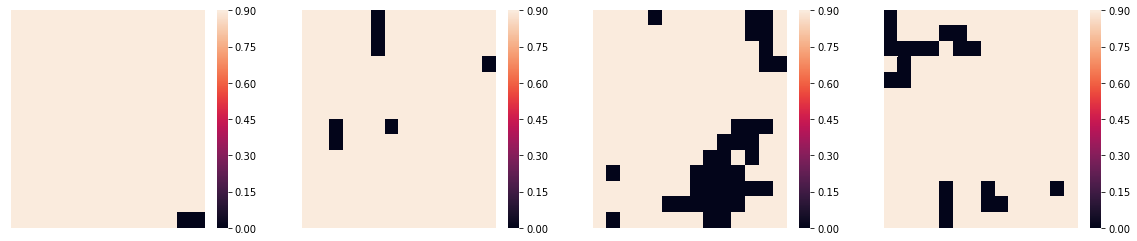

In [15]:
import random 
samples_x = [val for x, val in enumerate(nonzero) if kmeans.labels_[x] == 1]
print(samples_x)
randoms = random.sample(samples_x, 4)
randoms = [data_y[x] for x in randoms]
randoms = [x.reshape((14, 14)) for x in randoms]
multiplot(randoms)

In [16]:
percs = np.sum(data_y.reshape((-1, 14*14)), axis = 1)
idx = [x for x in range(0, len(data_y))]
print([i for x, i in enumerate(sorted(percs)) if x % (len(data_y)//15) == 0 ])

ids = {
    0: [x for x, z in zip(idx, percs) if 0 < z <= 5],
    1: [x for x, z in zip(idx, percs) if 5 < z <= 9],
    2: [x for x, z in zip(idx, percs) if 9 < z <= 14],
    3: [x for x, z in zip(idx, percs) if 14 < z <= 19],
    4: [x for x, z in zip(idx, percs) if 19 < z <= 27],
    5: [x for x, z in zip(idx, percs) if 27 < z <= 33],
    6: [x for x, z in zip(idx, percs) if 33 < z <= 41],
    7: [x for x, z in zip(idx, percs) if 41 < z <= 56],
    8: [x for x, z in zip(idx, percs) if 56  < z <= 93],
    9: [x for x, z in zip(idx, percs) if 93 < z <= 120],
    10: [x for x, z in zip(idx, percs) if 120 < z]
}

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 5.0, 9.0, 14.0, 19.0, 26.0, 32.0, 40.0, 55.0, 91.0, 196.0]


In [17]:
def balance_data(data_y, ids, labels, labels2, unaugmented = unaugmented):
    # Loop over the nonzero clusters
    #for i in range(0, NONZERO_CLUSTERS):
    #    tmp = [val for x, val in enumerate(nonzero) if labels[x] == i]
    #    ids[i] = tmp
    # Loop over the zero clusters
    for i in range(0, ZERO_CLUSTERS):
        tmp = [val for x, val in enumerate(zeros) if labels2[x] == i]
        ids[i + 11] = tmp
    #ids[10] = zeros
    return ids



In [18]:
ids = balance_data(data_y, ids, kmeans.labels_, kmeans_zero.labels_ )
items = [v for k, v in ids.items()]
items = [item for sublist in items for item in sublist]
print("The {} samples have been balanced between the sampling sites".format(len(items)))

The 663 samples have been balanced between the sampling sites


In [19]:
train_ids = []
test_ids = []
for i in ids:
    ln = len(ids[i])
    train_len = int(np.floor([ln * TRAIN_RATIO]))
    test_len = ln - train_len
    print(train_len, test_len, ln)
    trains = ids[i][:train_len]
    tests = ids[i][train_len:]
    train_ids += trains
    test_ids += tests
    
train_labels = []
for i in train_ids:
    train_labels.append([k for k, v in ids.items() if i in v][0])

46 12 58
36 10 46
33 9 42
36 10 46
36 9 45
33 9 42
36 9 45
32 8 40
35 9 44
12 4 16
21 6 27
24 6 30
35 9 44
36 10 46
32 8 40
8 2 10
33 9 42


In [20]:
print("Train and test characteristics:")
print("Train mean Y {}".format(np.mean([np.sum(x) for x in data_y[train_ids]])))
print("Test mean Y {}".format(np.mean([np.sum(x) for x in data_y[test_ids]])))
print("Train STD Y {}".format(np.std([np.sum(x) for x in data_y[train_ids]])))
print("Test STD Y {}".format(np.std([np.sum(x) for x in data_y[test_ids]])))
print("Train number with zero trees {}".format(0.2*len([x for x in data_y[train_ids] if np.sum(x) == 0])))
print("Test number with zero trees {}".format(0.8*len([x for x in data_y[test_ids] if np.sum(x) == 0])))
print("Train mean NDVI")
print("Test mean NDVI")
print("There are {} train and {} test samples".format(len(train_ids), len(test_ids)))
print("There is {} overlap between train and test".format(len([x for x in train_ids if x in test_ids])))


Train and test characteristics:
Train mean Y 25.32442748091603
Test mean Y 26.60431654676259
Train STD Y 37.14590705490665
Test STD Y 41.27110207226735
Train number with zero trees 33.6
Test number with zero trees 35.2
Train mean NDVI
Test mean NDVI
There are 524 train and 139 test samples
There is 0 overlap between train and test


# Augment training data

In [21]:
data_x_augmented = []
data_y_augmented = []
lengths_augmented = []
labels_augmented = []
for i, val in enumerate(train_ids):
    data_x_augmented.append(data_x[val])
    data_y_augmented.append(data_y[val])
    lengths_augmented.append(data_x[val].shape[0])
    labels_augmented.append(train_labels[i])
    
    x1 = np.flip(data_x[val], 1)
    y1 = np.flip(data_y[val], 0)
    lengths_augmented.append(x1.shape[0])
    labels_augmented.append(train_labels[i])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], [2, 1])
    y1 = np.flip(data_y[val], [1, 0])
    lengths_augmented.append(x1.shape[0])
    labels_augmented.append(train_labels[i])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], 2)
    y1 = np.flip(data_y[val], 1)
    lengths_augmented.append(x1.shape[0])
    labels_augmented.append(train_labels[i])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)

train_x = np.stack(data_x_augmented)
train_y = np.stack(data_y_augmented)
train_y = np.reshape(train_y, (train_y.shape[0], 14, 14, 1))
train_l = np.stack(lengths_augmented)
train_l = np.reshape(train_l, (train_y.shape[0], 1))

In [22]:
test_x = data_x[test_ids]
test_y = data_y[test_ids]
test_lengths = lengths[test_ids]

RANDOM TRAIN SAMPLES - SHOULD BE AUGMENTED


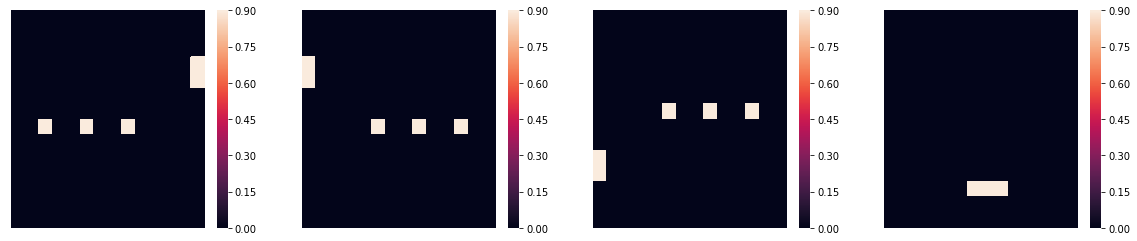

In [23]:
print("RANDOM TRAIN SAMPLES - SHOULD BE AUGMENTED")
multiplot([x.reshape(14, 14) for x in train_y[25:29]])

RANDOM TEST SAMPLES - SHOULD BE NOT AUGMENTED


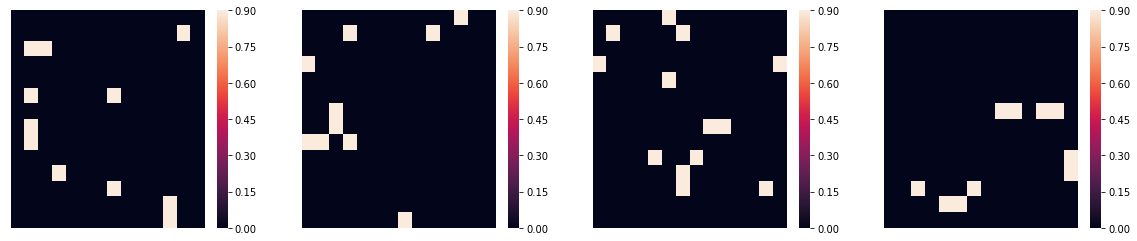

In [24]:
print("RANDOM TEST SAMPLES - SHOULD BE NOT AUGMENTED")
multiplot([x.reshape(14, 14) for x in test_y[25:29]])

# Loss definition

In [25]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
import math

def smooth_jaccard(y_true, y_pred, smooth=1):
    y_true = tf.reshape(y_true, (-1, 14*14))
    y_pred = tf.reshape(y_pred, (-1, 14*14))
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def focal_loss_fixed(y_true, y_pred, gamma = 2., alpha = 0.25):
    y_true = tf.reshape(y_true, (-1, 14*14, 1))
    y_pred = tf.reshape(y_pred, (-1, 14*14, 1))
    y_pred = K.clip(y_pred, 1e-8, 1-1e-8)
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
    pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
    pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
    loss = -K.mean(alpha * 1 * K.log(K.epsilon()+pt_1)) - K.mean((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return 2 * tf.reduce_mean(loss)

def bce_jaccard(y_true, y_pred):
    jac = smooth_jaccard(y_true, y_pred)
    bce = binary_crossentropy(y_true, y_pred)
    return bce + 0.15*tf.reshape(jac, (-1, 1, 1, 1))

def weighted_bce_loss(y_true, y_pred, weight = 1.25, smooth = 0.10, mask = None):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    y_true = K.clip(y_true, smooth, 1. - smooth)
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    loss = loss * mask
    return tf.reduce_mean(loss)

def lovasz_foc(y_true, y_pred):
    foc_losses = []
    #bce = weighted_bce_loss(y_true, y_pred, weight = 1.3)
    foc = focal_loss_fixed(y_true, y_pred, gamma = 1.5, alpha = 0.15)
    #lv_image = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    return foc# + 0.1*lv_image

from scipy.ndimage import distance_transform_edt as distance


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res

def calc_dist_map_batch(y_true):
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

def bce_lv(y_true, y_pred, alpha, smooth = 0.01, mask = None, ):
    #y_true_s = K.clip(y_true, smooth, 1. - smooth)
    bce =weighted_bce_loss(y_true, y_pred, mask = mask)
    surf = surface_loss(y_true, y_pred)
    #print(surf.shape)
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    return ((1 - alpha) * (bce + 0.2*lv) ) + (alpha * surf)# + 0.25*tf.reduce_mean(lv)



def lovasz(y_true, y_pred):
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    return tf.reduce_mean(lv)

def calculate_metrics():
    best_f1 = 0
    best_thresh = 0
    p = 0
    r = 0
    error = 0
    ys = []
    vls = []
    t_alls = []
    for m in test_ids:
        y, vl = sess.run([fm, test_loss], feed_dict={inp: test_x[m].reshape(1, STEPS, 14, 14, 17),
                                          length: test_lengths[m].reshape(1, 1),
                                          is_training: False,
                                          labels: test_y[m, :, :].reshape(1, 14, 14),
                                          })
        ys.append(y.reshape((14, 14)))
        vls.append(vl)
        t = test_y[m].reshape((14, 14))
        t_alls.append(t)
    for j in range(8, 12):
        tps = []
        fps = []
        fns = []
        perc_error = []
        trues = []
        preds = []
        val_loss = []
        for h in range(len(ys)):
            pred = ys[h]
            true = t_alls[h]
            vl = vls[h]
            pred[np.where(pred > j*0.05)] = 1
            pred[np.where(pred < j*0.05)] = 0
            true_s = np.sum(true)
            pred_s = np.sum(pred)
            #true_p = true_s - (true_s - pred_s)
            perc_error.append(abs(pred_s - true_s) / 196)
            tp, fp, fn = thirty_meter(true, pred)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            trues.append(true_s)
            preds.append(pred_s)
            val_loss.append(np.mean(vl))
        oa_error = abs(np.sum(preds) - np.sum(trues)) / np.sum(trues)
        precision = np.sum(tps) / (np.sum(tps) + np.sum(fps))
        recall = np.sum(tps) / (np.sum(tps) + np.sum(fns))
        f1 = 2*((precision* recall) / (precision + recall))
        if f1 > best_f1:
            best_f1 = f1
            p = precision
            r = recall
            error = oa_error
            best_thresh = j*0.05
    print("Val loss: {} Thresh: {} F1: {} Recall: {} Precision: {} Error: {}".format(np.around(np.mean(val_loss), 3), np.around(best_thresh, 2),
                                                                                     np.around(best_f1, 3), np.around(p, 3), np.around(r, 3), 
                                                                                     np.around(error, 3)))
    return best_f1

In [26]:
train_ids = [x for x in range(0, len(train_y))]
print(len(train_ids))

2096


# Equibatch creation

In [27]:

def equibatch(train_ids, lovasz = False):
    first_len = 5
    second_len = 9
    third_len = 14
    np.random.shuffle(train_ids)
    ix = train_ids
    percs = [np.sum(x) for x in train_y[ix]]
    zero_ids = [x for x, z in zip(ix, percs) if z == 0]
    one_ids = [x for x, z in zip(ix, percs) if 0 < z <= first_len]
    two_ids = [x for x, z in zip(ix, percs) if first_len < z <= second_len]
    three_ids = [x for x, z in zip(ix, percs) if second_len < z <= third_len]
    four_ids = [x for x, z in zip(ix, percs) if third_len < z <= 19]
    five_ids = [x for x, z in zip(ix, percs) if 19 < z < 27]
    six_ids = [x for x, z in zip(ix, percs) if 27 < z <= 33]
    seven_ids = [x for x, z in zip(ix, percs) if 33 < z <= 41]
    eight_ids = [x for x, z in zip(ix, percs) if 41 < z <= 56]
    nine_ids =  [x for x, z in zip(ix, percs) if 56 < z <= 80]
    ten_ids =  [x for x, z in zip(ix, percs) if 80 < z <= 120]
    eleven_ids = [x for x, z in zip(ix, percs) if 120 < z]
    #ten_ids = [x for x, z in zip(ix, percs) if 125 < z]
    
    

    all_ids = [x for x in [zero_ids, one_ids, two_ids, three_ids, four_ids, five_ids, six_ids,
              seven_ids, eight_ids, nine_ids, ten_ids, eleven_ids]]
    
    new_batches = []
    maxes = [len(zero_ids), len(one_ids), len(two_ids), len(three_ids), len(four_ids),
             len(five_ids), len(six_ids), len(seven_ids), len(eight_ids), len(nine_ids), len(ten_ids), len(eleven_ids)]#, len(ten_ids)]
    cur_ids = [0] * 12
    iter_len = len(train_ids)// 13
    for i in range(0, iter_len):
        random_ids = np.random.randint(0, 12, 3)
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 5:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [zero_ids[cur_ids[0]], zero_ids[cur_ids[0] + 1], one_ids[cur_ids[1]], two_ids[cur_ids[2]],
                    three_ids[cur_ids[3]], four_ids[cur_ids[4]], five_ids[cur_ids[5]],
                    six_ids[cur_ids[6]], seven_ids[cur_ids[7]], eight_ids[cur_ids[8]],
                               nine_ids[cur_ids[9]], ten_ids[cur_ids[10]], eleven_ids[cur_ids[11]],
                    ]
                    #all_ids[random_ids[0]][cur_ids[random_ids[0]]+1],
                    # all_ids[random_ids[1]][cur_ids[random_ids[1]]+1],
                    # all_ids[random_ids[2]][cur_ids[random_ids[2]]]+1]
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        cur_ids[0] += 1
        #for x in random_ids:
        #    cur_ids[x] += 1
        
    new_batches = [item for sublist in new_batches for item in sublist]
    #overlap = [x for x in new_batches if x in test_ids]
    #print("There is {} overlap. Error if > 0".format(len(overlap)))
    return new_batches

In [28]:
batch = equibatch(train_ids, True)

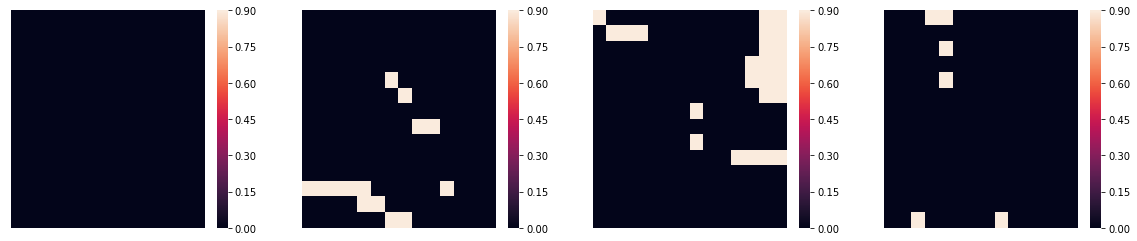

In [29]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[:4]]])

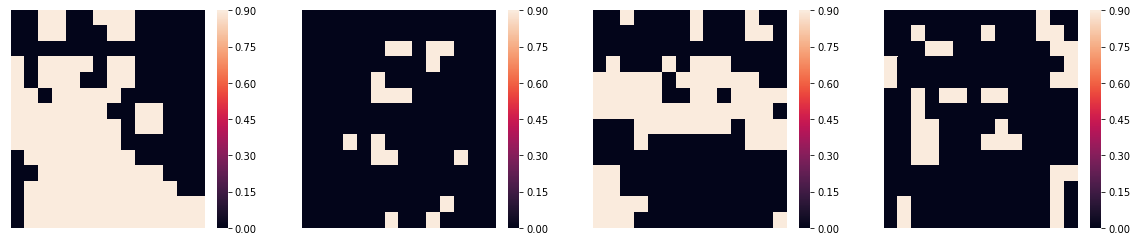

In [30]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[4:8]]])

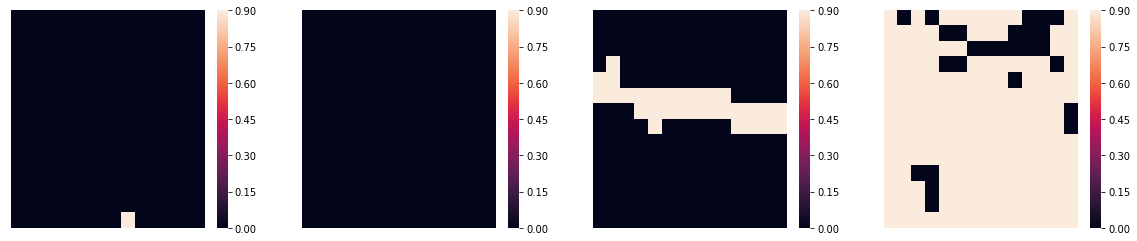

In [31]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[8:12]]])

In [32]:
np.mean([np.sum(x) for x in train_y[batch]])

38.29861442904921

In [33]:
#new_saver = tf.train.import_meta_graph('../models/f1_auc/model.meta')
#new_saver.restore(sess, tf.train.latest_checkpoint('../models/f1_auc/'))

In [34]:
# Experiment log
# Temporal FPA with concat, 0.05 BCE Smooth w/o Lovasz and 12 step  =  
#                                           w/ 0.2 Lovasz per image =
#                                           w/ 0.2 Lovasz per batch =
#                                           w/ 0.4 Lovasz per image =
#                                           w/ 0.4 Lovasz per batch =              

In [35]:
def get_batch_loss_weights(idx):
    weights = []
    for i in idx:
        mask = np.copy(np.reshape(train_y[i], (14, 14)))
        zeros = np.argwhere(mask == 0)

        loss_mask = np.ones((14, 14))
        for x, y in zeros:
            if x < 13:
                if mask[x+1, y] == 1:
                    loss_mask[x, y] = 0.8
            if x > 0:
                if mask[x - 1, y] == 1:
                    loss_mask[x, y] = 0.8
            if y > 0:
                if mask[x, y - 1] == 1:
                    loss_mask[x, y] = 0.8
            if y < 13:
                if mask[x, y + 1] == 1:
                    loss_mask[x, y] = 0.8
        weights.append(loss_mask)
    
    return np.reshape(np.stack(weights), (-1, 14, 14, 1))

loss_weights = tf.placeholder(tf.float32, shape=(None, 14, 14, 1))
alpha = tf.placeholder(tf.float32, shape = ())

# Model training

In [43]:
FRESH_START = False
FINE_TUNE = False
from tensorflow.python.keras.optimizers import SGD
learning_rate = tf.placeholder(tf.float32, shape=[])


BATCH_SIZE = 48
print("Starting model with: \n {} zone out \n {} l2 \n {} initial LR \n {} final LR \n {} parameters"
     .format(ZONE_OUT_PROB, L2_REG, INITIAL_LR, FINAL_LR, total_parameters))
best_val = 0.620
if not FRESH_START:
    print("Resuming training with a best validation score of {}".format(best_val))
if FRESH_START:
    print("Restarting training from scratch on {} train and {} test samples, total {}".format(len(train_ids), len(test_ids), N_SAMPLES))

    optimizer = tf.train.AdamOptimizer(5e-4, epsilon = 1e-8)
    #optimizer = AdaBoundOptimizer(1e-2, 1e-2, amsbound = True)

    ft_optimizer = tf.train.AdamOptimizer(1e-4, epsilon = 1e-3)
    ft_optimizer = tf.contrib.estimator.clip_gradients_by_norm(ft_optimizer, clip_norm=1.0)
    
    train_loss = bce_lv(tf.reshape(labels, (-1, 14, 14, 1)), fm, alpha = alpha, mask = loss_weights)
    test_loss = tf.reduce_mean(binary_crossentropy(tf.reshape(labels, (-1, 14, 14, 1)), fm))
    ft_loss = lovasz(tf.reshape(labels, (-1, 14, 14, 1)), fm)
    #l2_loss = tf.losses.get_regularization_loss()
    #train_loss += l2_loss
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        #wu_op = wu_optimizer.minimize(wu_loss)
        ft_op = ft_optimizer.minimize(ft_loss)
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 2)

# Run training 1oop
for i in range(10, 300):
    randomize = equibatch(train_ids, lovasz = False)
    randomize = [np.min([x, len(train_y) - 1]) for x in randomize]
    #randomize = [x for x in range(0, len(train_ids))]
    #np.random.shuffle(randomize)
        #print("Loss: BCE + 0.30 Lovasz")
    op = train_op
    loss = train_loss
    #op = ft_op
    #loss = ft_loss
    BATCH_SIZE = 13
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    bce_losses = []
    
    al = np.min([i*0.01, 0.75])
    print(al)
    
    for k in tnrange(int(len(train_ids) // BATCH_SIZE)):
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        batch_y = train_y[batch_ids, :, :].reshape(len(batch_ids), 14, 14)
        opt, tr = sess.run([op, loss],
                              feed_dict={inp: train_x[batch_ids, :, :, :],
                                         length: train_l[batch_ids].reshape((-1, 1)),
                                         labels: batch_y,
                                         is_training: True,
                                         keep_rate: np.max((1 - (i*0.002), 0.75)),
                                         loss_weights: get_batch_loss_weights(batch_ids),
                                         alpha: al
                                         })
        losses.append(tr)
    
    print("Epoch {}: Loss {}".format(i, np.around(np.mean(losses[:-1]), 3)))
    f1 = calculate_metrics()
    if f1 > best_val:
        best_val = f1
        print("Saving model with {}".format(f1))
        save_path = saver.save(sess, "../models/f1_auc/model")

Starting model with: 
 0.05 zone out 
 0.0 l2 
 0.0002 initial LR 
 0.001 final LR 
 37570 parameters
Resuming training with a best validation score of 0.62
0.1


Epoch 10: Loss 0.6039999723434448
Val loss: 0.3149999976158142 Thresh: 0.4 F1: 0.579 Recall: 0.559 Precision: 0.6 Error: 0.074
0.11


Epoch 11: Loss 0.5929999947547913
Val loss: 0.3269999921321869 Thresh: 0.4 F1: 0.563 Recall: 0.507 Precision: 0.633 Error: 0.249
0.12


Epoch 12: Loss 0.5849999785423279
Val loss: 0.35100001096725464 Thresh: 0.4 F1: 0.548 Recall: 0.454 Precision: 0.691 Error: 0.52
0.13


Epoch 13: Loss 0.5740000009536743
Val loss: 0.33399999141693115 Thresh: 0.4 F1: 0.551 Recall: 0.474 Precision: 0.656 Error: 0.383
0.14


Epoch 14: Loss 0.5640000104904175
Val loss: 0.3440000116825104 Thresh: 0.4 F1: 0.523 Recall: 0.459 Precision: 0.607 Error: 0.323
0.15


Epoch 15: Loss 0.5580000281333923
Val loss: 0.3490000069141388 Thresh: 0.4 F1: 0.529 Recall: 0.433 Precision: 0.68 Error: 0.569
0.16


Epoch 16: Loss 0.546999990940094
Val loss: 0.30399999022483826 Thresh: 0.4 F1: 0.559 Recall: 0.563 Precision: 0.556 Error: 0.012
0.17


Epoch 17: Loss 0.5360000133514404
Val loss: 0.33899998664855957 Thresh: 0.4 F1: 0.535 Recall: 0.454 Precision: 0.651 Error: 0.433
0.18


Epoch 18: Loss 0.5260000228881836
Val loss: 0.34200000762939453 Thresh: 0.4 F1: 0.54 Recall: 0.464 Precision: 0.647 Error: 0.396
0.19


Epoch 19: Loss 0.5180000066757202
Val loss: 0.3070000112056732 Thresh: 0.4 F1: 0.535 Recall: 0.546 Precision: 0.525 Error: 0.037
0.2


Epoch 20: Loss 0.5139999985694885
Val loss: 0.3190000057220459 Thresh: 0.4 F1: 0.528 Recall: 0.494 Precision: 0.566 Error: 0.147
0.21


Epoch 21: Loss 0.5049999952316284
Val loss: 0.3199999928474426 Thresh: 0.4 F1: 0.501 Recall: 0.48 Precision: 0.522 Error: 0.088
0.22


Epoch 22: Loss 0.4950000047683716
Val loss: 0.30399999022483826 Thresh: 0.4 F1: 0.552 Recall: 0.548 Precision: 0.557 Error: 0.016
0.23


Epoch 23: Loss 0.4869999885559082
Val loss: 0.29499998688697815 Thresh: 0.4 F1: 0.567 Recall: 0.578 Precision: 0.556 Error: 0.038
0.24


Epoch 24: Loss 0.47999998927116394
Val loss: 0.31700000166893005 Thresh: 0.4 F1: 0.519 Recall: 0.51 Precision: 0.529 Error: 0.036
0.25


Epoch 25: Loss 0.4699999988079071
Val loss: 0.3100000023841858 Thresh: 0.4 F1: 0.544 Recall: 0.522 Precision: 0.568 Error: 0.088
0.26


Epoch 26: Loss 0.46299999952316284
Val loss: 0.31200000643730164 Thresh: 0.4 F1: 0.544 Recall: 0.512 Precision: 0.581 Error: 0.135
0.27


Epoch 27: Loss 0.45399999618530273
Val loss: 0.3009999990463257 Thresh: 0.4 F1: 0.516 Recall: 0.569 Precision: 0.472 Error: 0.172
0.28


Epoch 28: Loss 0.4449999928474426
Val loss: 0.31200000643730164 Thresh: 0.4 F1: 0.529 Recall: 0.542 Precision: 0.517 Error: 0.046
0.29


Epoch 29: Loss 0.4410000145435333
Val loss: 0.2980000078678131 Thresh: 0.4 F1: 0.539 Recall: 0.56 Precision: 0.52 Error: 0.071
0.3


Epoch 30: Loss 0.43299999833106995
Val loss: 0.2980000078678131 Thresh: 0.4 F1: 0.52 Recall: 0.582 Precision: 0.469 Error: 0.195
0.31


Epoch 31: Loss 0.421999990940094
Val loss: 0.3019999861717224 Thresh: 0.4 F1: 0.514 Recall: 0.58 Precision: 0.461 Error: 0.204
0.32


Epoch 32: Loss 0.41600000858306885
Val loss: 0.3059999942779541 Thresh: 0.4 F1: 0.522 Recall: 0.553 Precision: 0.494 Error: 0.106
0.33


Epoch 33: Loss 0.41999998688697815
Val loss: 0.3019999861717224 Thresh: 0.4 F1: 0.516 Recall: 0.55 Precision: 0.486 Error: 0.117
0.34


Epoch 34: Loss 0.44600000977516174
Val loss: 0.29600000381469727 Thresh: 0.4 F1: 0.566 Recall: 0.527 Precision: 0.61 Error: 0.157
0.35000000000000003


Epoch 35: Loss 0.41100001335144043
Val loss: 0.296999990940094 Thresh: 0.4 F1: 0.553 Recall: 0.54 Precision: 0.566 Error: 0.049
0.36


KeyboardInterrupt: 

# Model validation and sanity checks





In [44]:
start = 0
test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show()
start = 40





0.37410071942446044
52
53
54
55
56
57
58
59


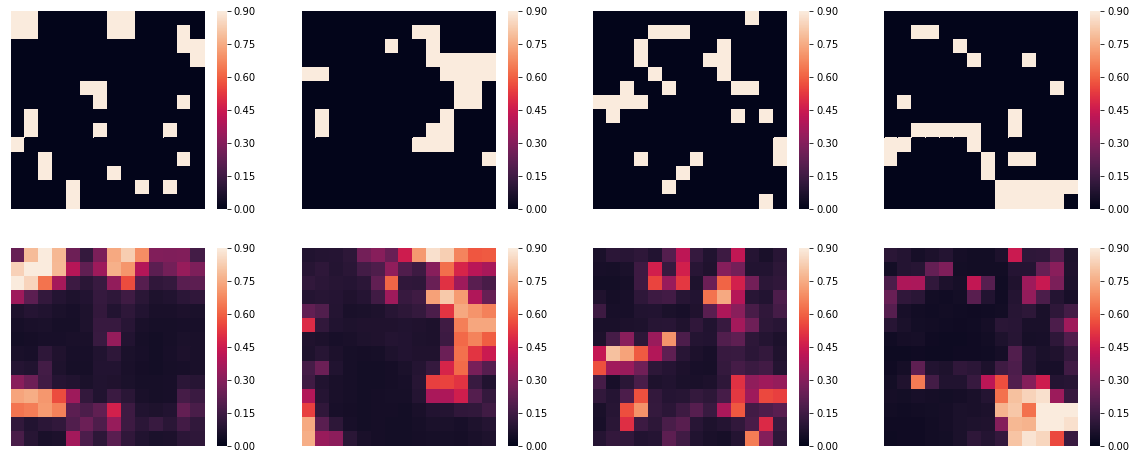

In [48]:
import random 

    
test_losses = []
print(start/len(test_ids))
test_ids = sorted(test_ids)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
#matrix_ids = random.sample(test_ids, 4)z

preds = []
trues = []
for i in matrix_ids:
    idx = i
    print(i)
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, STEPS, IMAGE_SIZE, IMAGE_SIZE, 17),
                                  length: test_lengths[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    true = test_y[idx].reshape(LABEL_SIZE, LABEL_SIZE)
    trues.append(true)
    

to_plot = trues[0:4] + preds[0:4]# + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 2, ncols = 4)
#plot_ids[ordering[976]//4] 

start = start + 4

In [ ]:
import random 

    
test_losses = []
print(start/len(test_ids))
test_ids = sorted(test_ids)
#matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
#              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
matrix_ids = random.sample(train_ids, 4)

preds = []
trues = []
for i in matrix_ids:
    idx = i
    print(i)
    y = sess.run([fm], feed_dict={inp: train_x[idx].reshape(1, STEPS, IMAGE_SIZE, IMAGE_SIZE, 17),
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    true = train_y[idx].reshape(LABEL_SIZE, LABEL_SIZE)
    trues.append(true)
    

to_plot = trues[0:4] + preds[0:4]# + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 2, ncols = 4)
#plot_ids[ordering[976]//4] 
start = start + 4

In [ ]:
plot_ids2 = [val for x, val in enumerate(plot_ids) if x not in list(set([x // 4 for x in outliers]))]
plot_ids2[ordering[460]//4] 

# Calculate ROC for best threshold selection

In [ ]:
calculate_metrics()

## TODO @jombrandt top 10 worst training, test samples by IOU 

These should be written to a tmp/ .txt file and indexed by validate-data.ipynb to ensure that original classifications were correct, and to identify regions that need more training data.